# | P7 - Détection de Bad Buzz via du Deep Learning

<img src="https://user.oc-static.com/upload/2019/10/22/15717382019055_Capture%20d%E2%80%99e%CC%81cran%202019-10-22%20a%CC%80%2011.50.29.png">



En tant qu'ingénieur IA chez MIC (Marketing Intelligence Consulting), une entreprise de conseil spécialisée sur les problématiques de marketing digital, nous sommes missionnés pour créer un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux.

Air Paradis souhaite le prototype d’un produit IA permettant de prédire le sentiment associé à un tweet, mais ne dispose pas de suffisamment de données pour ce projet. Pour cela, nous utiliserons les données Open Source disponibles à l'adresse suivante : https://www.kaggle.com/kazanova/sentiment140. 

Ces données contiennent des informations relatives aux tweets postés sur le réseau social (utilisateur ayant posté, contenu, moment du post) et un label binaire (tweet exprimant un sentiment négatif ou non).


Le prototype fonctionnel du modèle permettra de récupérer la prédiction de sentiment d'un tweet envoyé en entrée.

Pour la réalisation de ce projet, nous aborderons 3 types d'approche :
1. Approche “API sur étagère” en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment.

2. Approche “Modèle sur-mesure simple” en utilisant le Concepteur / Designer d’un service Azure Machine Learning, permettant de prédire le sentiment associé à un tweet.

3. Approche “Modèle sur-mesure avancé” en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet.

# Observation & transformation des données

Le jeu de données mis à disposition contient 1 600 000 lignes, caractérisées par 6 variables :
- le label : 0 pour un tweet négatif, 4 pour un tweet positif
- l'identifiant numérique de l'utilisateur ayant posté le tweet
- la date de publication du tweet
- un flag permettant de déterminer le type de donnée
- le nom d'utilisateur de l'internaute ayant posté le tweet
- le texte du tweet

Par la suite nous observerons la distribution du nombre de mots par tweet ainsi que la répartition des tweet dans le temps.

,label,identifiant,date,flag,user_name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Le jeu de données fourni contient 1581466 tweets uniques.
En moyenne les tweets de ce jeu de données contiennent 74.09011125 caractères.
En moyenne les tweets négatif de ce jeu de données contiennent 73.8784325 caractères.


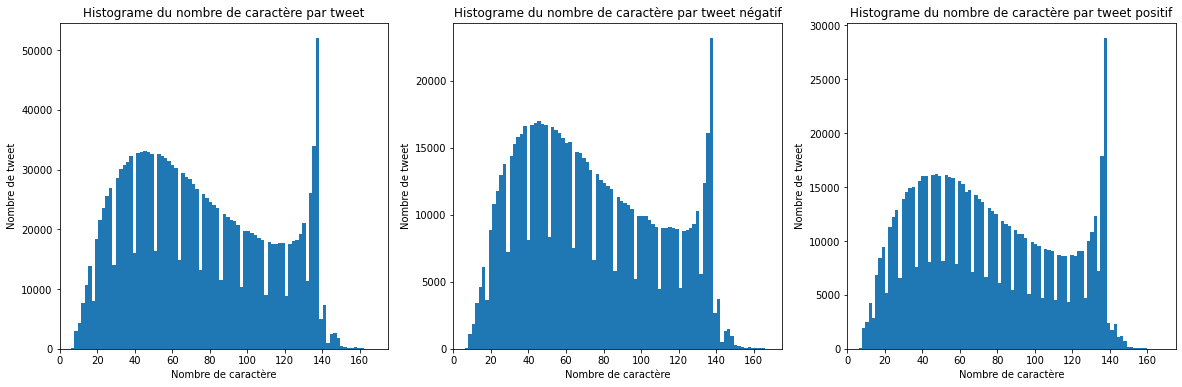

En moyenne les tweets positifs de ce jeu de données contiennent 74.30179 caractères.


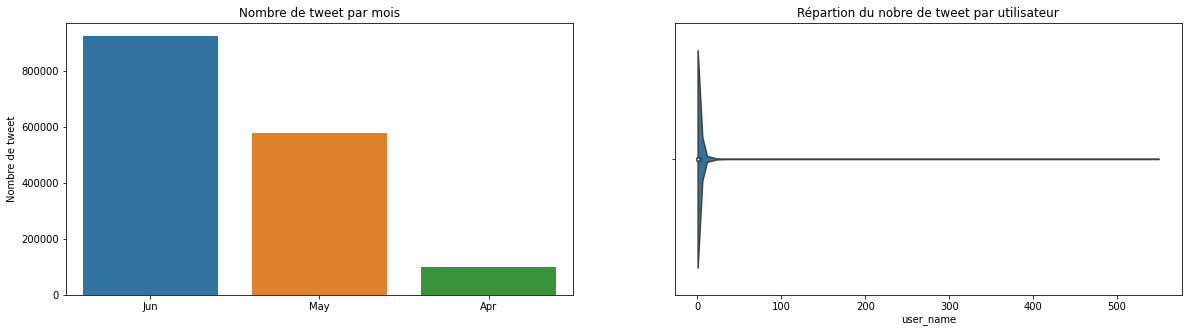

In [64]:
from functions import *
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('utile/training.1600000.processed.noemoticon.csv',
                 encoding="ISO-8859-1",
                 names=["label","identifiant","date","flag","user_name","text"])

display(df.head(5))

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
print(f"Le jeu de données fourni contient {len(df.drop_duplicates('text'))} tweets uniques.")
plt.title("Histograme du nombre de caractère par tweet")
plt.xlabel("Nombre de caractère")
plt.ylabel("Nombre de tweet")
plt.xlim(0,175)
plt.hist(df.text.apply(len), bins=200)

print(f"En moyenne les tweets de ce jeu de données contiennent {df.text.apply(len).mean()} caractères.")

plt.subplot(1,3,2)
plt.title("Histograme du nombre de caractère par tweet négatif")
plt.xlabel("Nombre de caractère")
plt.ylabel("Nombre de tweet")
plt.hist(df[df.label == 4].text.apply(len), bins=200)
plt.xlim(0,175)
print(f"En moyenne les tweets négatif de ce jeu de données contiennent {df[df.label == 4].text.apply(len).mean()} caractères.")

plt.subplot(1,3,3)
plt.title("Histograme du nombre de caractère par tweet positif")
plt.xlabel("Nombre de caractère")
plt.ylabel("Nombre de tweet")
plt.hist(df[df.label == 0].text.apply(len), bins=200)
plt.xlim(0,175)
plt.show()
print(f"En moyenne les tweets positifs de ce jeu de données contiennent {df[df.label == 0].text.apply(len).mean()} caractères.")

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Nombre de tweet par mois')
sns.barplot(df.date.apply(lambda x: x.split()[1]).value_counts().index, 
            df.date.apply(lambda x: x.split()[1]).value_counts().values)
plt.ylabel('Nombre de tweet')

plt.subplot(1,2,2)
plt.title('Répartion du nobre de tweet par utilisateur')
sns.violinplot(df.user_name.value_counts())
plt.show()

Nous observons une grande proportion des tweets publiés en juin 2019 dans notre jeu de données avec une moyenne de 2.42 tweets par utilisateur. [lost_dog] étant l'utilisateur ayant posté le plus de tweet avec 549 tweets envoyés.

Par la suite, nous observerons les données textuelles sur un échantillon de 1600 tweets.

Dans un premier temps, nous observerons la mesure de cohérence du nombre de topic pour cet échantillon, puis nous affichons un nuage des mots les plus présent dans notre corpus ainsi qu'une projection de ces mots. Enfin nous affichons une visualisation des topics déterminés pour 12 sujets.



Notre jeu de données suivra un traitement qui visera à alléger la quantité d'information en vue de son utilisation pour l'entraînement de notre modèle de détection de sentiments. Pour cela :
- les valeurs dupliquées seront supprimées.
- seules les variable "text" et "label" seront conservées
- les variables "label" de valeur '4' seront remplacé par la valeur '1'
- 800 commentaires négatifs et 800 commentaires positifs seront conservés.

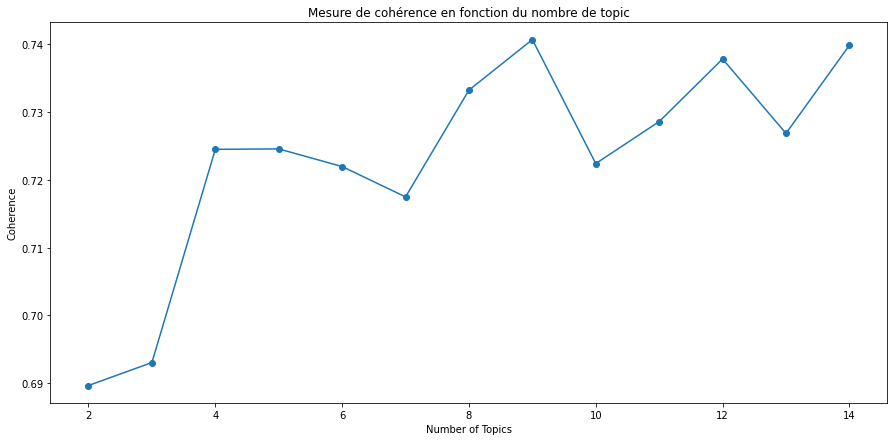

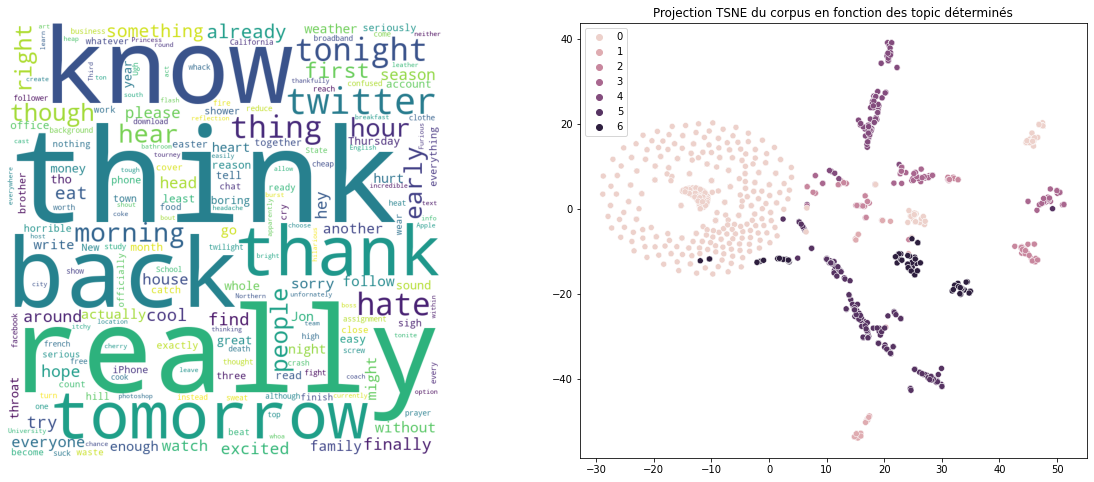

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.226746  0.000623       1        1  17.573632
3     -0.100075 -0.092138       2        1  16.060740
6     -0.045829  0.193390       3        1  14.772478
0      0.023729 -0.067473       4        1  13.294997
2     -0.039098  0.008264       5        1  13.011453
1     -0.037714 -0.024170       6        1  12.915411
4     -0.027758 -0.018495       7        1  12.371289, topic_info=         Term       Freq      Total Category  logprob  loglift
16      think  24.000000  24.000000  Default  30.0000  30.0000
12      thank  22.000000  22.000000  Default  29.0000  29.0000
56       hear  11.000000  11.000000  Default  28.0000  28.0000
44       know  20.000000  20.000000  Default  27.0000  27.0000
30       hate  13.000000  13.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
193   twitter   1.534542  13.766257   Topic7  -4.7965  -0.1042
301  everyone   1.152123   5.092686   Topic7  -5.0831   0.6036
31     people   0.958425   8.994273   Topic7  -5.2672  -0.1493
23      would   0.923885   6.235290   Topic7  -5.3039   0.1804
7         the   0.826642   9.518645   Topic7  -5.4151  -0.3538

[313 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
539       4  0.730252        Ai
320       3  0.579708     Apple
468       6  0.538663    Austin
417       6  0.734782  Bioshock
375       7  0.729200     Brian
...     ...       ...       ...
170       1  0.948172     write
261       4  0.264427      year
261       6  0.528854      year
2         2  0.094204       you
2         4  0.753635       you

[347 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 7, 1, 3, 2, 5])

CPU times: user 2min 44s, sys: 14 s, total: 2min 58s
Wall time: 2min 40s


/Users/kevinduranty/miniforge3/envs/p7/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/kevinduranty/miniforge3/envs/p7/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/kevinduranty/miniforge3/envs/p7/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/kevinduranty/miniforge3/envs/p7/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/kevinduranty/miniforg

In [65]:
%%time

def change(x):
    if x == 4: return 1
    else :return 0

df = df.drop_duplicates('text')
df = df[["text","label"]]
df_ = pd.concat([df[df.label == 0][:800], df[df.label == 4][:800]], axis=0).reset_index().drop(['index'], axis=1)

df_.label = df_.label.apply(change)
df_.to_csv('utile/data.csv')

tokens, df_, BOW, tfidf, vec = traitement_nlp(df_)
with open('utile/tokens', 'wb') as f:pickle.dump(tokens, f, protocol=pickle.HIGHEST_PROTOCOL)
showing_topics(df_, tokens, vec, tfidf)

[A compléter]


# Approche méthodologique

Dans cette partie, nous détaillons la démarche méthodologique qui sera appliquée pour la comparaison des modèles de détection des sentiments.

<b> Jeu de données</b>

Durant toute notre étude le même jeu de données sera conservé, il sera constitué de 1600 tweets, soit 0,1% de notre jeu de données initiale, et des variable 'texte' et 'label' de manière uniformément réparties.
- 0 signifie que le tweet porte un sentiment négatif.
- 1 signifie que le tweet porte un sentiment positif.

<img src="https://user.oc-static.com/upload/2017/03/02/14884666421501_P2C1-1.png">

<b> Les métriques </b>

Afin de construire un modèle performant, nous procéderons en premier lieu à définir les métriques qui serviront à caractériser les performances des modèles, ensuite nous sélectionnerons les modèles de classification binaire pouvant répondre à notre problématique. 


Avant de sélectionnez nos métriques, revenons sur les définitions fondamentales en classification binaire.
Comme présenté sur la figure ci-dessus, il existe plusieurs cas de figure lorsque notre modèle prédit un résultat :
- Le résultat est <b>Négatif</b>: La prédiction du tweet est négative (0).
- Le résultat est <b>Positif</b> : La prédiction du tweet est positive (1).
- Le résultat est <b>Vrai</b> : Le modèle a prédit correctement la cible.
- Le résultat est <b>Faux</b> : Le modèle n'a pas prédit correctement la cible.

Ainsi il extiste quatre situations possibles :
- Le résultat est <b> Vrai Positif (VP)</b> : La prédiction est vrai sur le tweet positif .
- Le résultat est <b> Vrai Négatif (VN)</b> : La prédiction est vrai sur le tweet négatif.
- Le résultat est <b> Faux Positif (FP)</b> : La prédiction est fausse sur le tweet positif.
- Le résultat est <b> Faux Négatif (FN)</b> : La prédiction est fausse sur le tweet négatif.

Notre objectif est de prédire correctement les tweets négatifs et donc de veiller à ce que la proportion des faux négatifs soit la plus faible possible, c'est-à-dire lorsque le modèle prédit que le tweet est positif et se trompe.

Pour cela, nous pouvons calculer plusieurs indicateurs :
- La précision : VP / (VP+FP) proportion de vrai positif sur l'ensemble des positifs prédits.
- Rappel : VP / (VP + FN) proportion de prédiction correcte parmi les tweets positifs.
- f1 score : 2(precision*rapel)/(precision+rapel) qui est la moyenne harmonique de la précision et du rappel, plus F1 est proche de 1 plus la précision et le rappel seront grand. Une grande valeur de F1 signifie que le modèle prédit correctement les Vrais positifs.

Nous observerons également d'autres métriques complémentaires aux deux précédentes :
- Temps d'entraînement, ce qui nous permettra d'observer les modèles qui apprennent les plus vite.

Enfin, nous observerons 2 graphiques :
- La Matrice de confusion, qui synthétisera dans un graphe les différentes valeurs : VP, FP, FP, FN
- La courbe d'apprentissage, qui affichera l'évolution de l'apprentissage du modèle en fonction du pourcentage du jeu de données utilisé pour l'apprentissage.

<b> Les approches observées </b>

Nous observerons trois approches différentes :
1. API sur étagère : Nous observerons la prédiction du service cognitif de Microsoft Azure à partir des données textes non modifiés.
3. Modèle sur mesure simple : Nous construirons un modèle de classification binaire à partir de l'outil concepteur de Microsoft Azure ML
3. Modèle sur mesure avancé : Nous construirions un modèle de classification à partir de modèle deepLearning

Enfin, nous comparerons ces différentes approches afin de sélectionner la meilleure puis nous la déploierons sur les services clouds de Microsoft Azure.